In [ ]:
!pip3 install transformers

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)
from tqdm.notebook import tqdm

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, random_split, DataLoader

from torchtext.data import Field, LabelField, Dataset, Example, TabularDataset
from torchtext.data import BucketIterator

import os
import time
import random
import re

from transformers import BertTokenizer, BertForSequenceClassification

from collections import defaultdict
from IPython.display import clear_output

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DEBUG = False

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

print(device)

cuda


По условию, необходимо как предсказывать тип комментария(позитивный или негативный), так и оценку фильма автором этого комментария. Можно выделить следующие подходы к решению задачи:

1. Предсказываем вероятность того, что комментарий положительный. Лосс -- BCEWithLogits. Метрики -- любые для бинарной классификации: accuracy, precision, recall, F1, ROC AUC. Так как в имеющихся данных классы идеально сбалансированы, достаточно смотреть только на accuracy. Далее подбираем рейтинг комментария по вероятности того, что он позитивный.

2. Предсказываем рейтинг, а потом по рейтингу определяем тип комментария. Проблема этого подхода заключается в том, что в датасете отсутствуют комментарии с рейтингом 5 или 6, поэтому эти рейтинги никогда не будут предсказываться без дополнительных ухищрений. Лосс - кросс-энтропия, метрики -- accuracy или макро-усреднение метрик бинарной классификации.

3. Третий подход заключается в объединении первых двух при помощи multi-task модели, то есть на каждую из задач будет выделена отдельная голова. Этот подход сохраняет недостатки второго подхода, а также возможна ситуация, при которой предсказанные рейтинг и класс комментария будут противоречить друг другу.

Остановимся на первом подходе. Для начала прочитаем данные и выполним предобработку. 

In [ ]:
!cp /content/drive/'My Drive'/'Colab Data'/Гринатом/aclImdb_v1.tar.gz .
!tar -xf aclImdb_v1.tar.gz

In [ ]:
def read_data(path):
    texts = []
    labels = []
    for dir, label in zip(['pos', 'neg'], [1, 0]):
        dir_path = os.path.join(path, dir)
        files = os.listdir(dir_path)
        for file in files:
            with open(os.path.join(dir_path, file)) as f:
                text = f.read()
                texts.append(text)
                labels.append(label)

    df = pd.DataFrame({'text': texts, 'label': labels})
    return df

In [ ]:
train = read_data('aclImdb/train')
train

,text,label
0,"My friend and I picked ""Paperhouse"" out of a r...",1
1,Rented and watched this short (< 90 minutes) w...,1
2,"This film has great acting, great photography ...",1
3,I remember this movie. Quite intense for an 11...,1
4,It's difficult to not have a liking for Israel...,1
...,...,...
24995,"Much of ""Over Her Dead Body"" is so painfully u...",0
24996,"Okay, let me start off by saying that nothing ...",0
24997,SPOILER ALERT In this generic and forgettable ...,0
24998,"If anybody really wants to understand Hitler, ...",0


In [ ]:
test = read_data('aclImdb/test')
test

,text,label
0,"I just saw ""Eagle´s wing"". I do not really kno...",1
1,I remember seeing this film in the theater in ...,1
2,"Fascinating and amusingly bad, Lights of New Y...",1
3,I have to say that some of the other reviews o...,1
4,"A clever and bizarre angle to ""Beauty is in th...",1
...,...,...
24995,This is one of those movies where I was rootin...,0
24996,Pluses: Mary Boland is delightfully on edge as...,0
24997,"no really, im not kidding around here folks, a...",0
24998,"Apart from some quite stunning scenery, this S...",0


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;:]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
# в отзывах иногда встречаются HTML-теги
TAGS_RE = re.compile('<[^<>]+>')


def clean_text(text):
    text = text.lower()
    text = TAGS_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = re.sub('\s+', ' ', text) 
    return text
    

Пример чистки текста:

In [ ]:
train.text[0]

'My friend and I picked "Paperhouse" out of a random pile of movies on our weekly excursion to the Horror section-- neither of us had heard of it, but the blurb on the box was really promising. And the movie didn\'t disappoint, though I still probably wouldn\'t call it a horror movie exclusively.<br /><br />11-year old Anna Madden draws a house, and visits it in her dreams. She is definitely asleep when she\'s seeing the house, but it\'s so real in a sense that it\'s almost like a completely separate reality. Which, in view of later events, doesn\'t seem like a far cry from the truth. Anyhow, she finds she can add to the house, its contents and its surroundings by simply adding to the picture. <br /><br />While this is going on, Anna is getting increasingly more ill with a fever, and besides that is getting totally obsessed with the house and her drawing. On top of that, she and her mother are also dealing with her absent father; he has a job that takes him away for long stretches, tho

In [ ]:
clean_text(train.text[0])

'my friend and i picked paperhouse out of a random pile of movies on our weekly excursion to the horror section neither of us had heard of it but the blurb on the box was really promising and the movie didnt disappoint though i still probably wouldnt call it a horror movie exclusively 11year old anna madden draws a house and visits it in her dreams she is definitely asleep when shes seeing the house but its so real in a sense that its almost like a completely separate reality which in view of later events doesnt seem like a far cry from the truth anyhow she finds she can add to the house its contents and its surroundings by simply adding to the picture while this is going on anna is getting increasingly more ill with a fever and besides that is getting totally obsessed with the house and her drawing on top of that she and her mother are also dealing with her absent father he has a job that takes him away for long stretches though one gets the impression theres actually more to the stor

In [ ]:
train['text'] = train['text'].apply(clean_text)
train

,text,label
0,my friend and i picked paperhouse out of a ran...,1
1,rented and watched this short 90 minutes work ...,1
2,this film has great acting great photography a...,1
3,i remember this movie quite intense for an 11 ...,1
4,its difficult to not have a liking for israeli...,1
...,...,...
24995,much of over her dead body is so painfully unf...,0
24996,okay let me start off by saying that nothing i...,0
24997,spoiler alert in this generic and forgettable ...,0
24998,if anybody really wants to understand hitler r...,0


In [ ]:
test['text'] = test['text'].apply(clean_text)
test

,text,label
0,i just saw eagles wing i do not really know wh...,1
1,i remember seeing this film in the theater in ...,1
2,fascinating and amusingly bad lights of new yo...,1
3,i have to say that some of the other reviews o...,1
4,a clever and bizarre angle to beauty is in the...,1
...,...,...
24995,this is one of those movies where i was rootin...,0
24996,pluses mary boland is delightfully on edge as ...,0
24997,no really im not kidding around here folks and...,0
24998,apart from some quite stunning scenery this st...,0


Начнём с бейзлайна: будем получать эмбеддинги комментариев с помощью TF-IDF, а затем применять к ним модель Naive Bayes.

### Бейзлайн: tf-idf + Naive Bayes

In [ ]:
%%time
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train['text'], train['label'])

y_pred = nb.predict(test['text'])

print('accuracy %s' % accuracy_score(y_pred, test['label']))

accuracy 0.83064
CPU times: user 8.25 s, sys: 151 ms, total: 8.4 s
Wall time: 8.44 s


Как видно, такая модель очень быстро обучается и работает, а также показывает не самое плохое качество.

Следующим шагом будет модель, получающая эмбеддинги слов с помощью специального слоя(nn.Embedding), а затем передающая их в RNN. Предположительно, такая модель не будет показывать слишком хорошие результаты из-за того, что эмбеддинги учатся с нуля, а в трейне всего $20 000$ текстов($5000$ отберём для валидации). Этот недостаток можно было бы смягчить, если использовать неразмеченные данные для обучения эмбеддингов, или же использовать метод, описанный в рекомендованной статье. Также неплохим вариантом кажется взять предобученные эмбеддинги.

Для удобства, используем здесь даталоадер из `torchtext`, который автоматически сгруппирует в батчи тексты одинаковой длины. 

### RNN

Посмотрим на распределение длин комментариев.

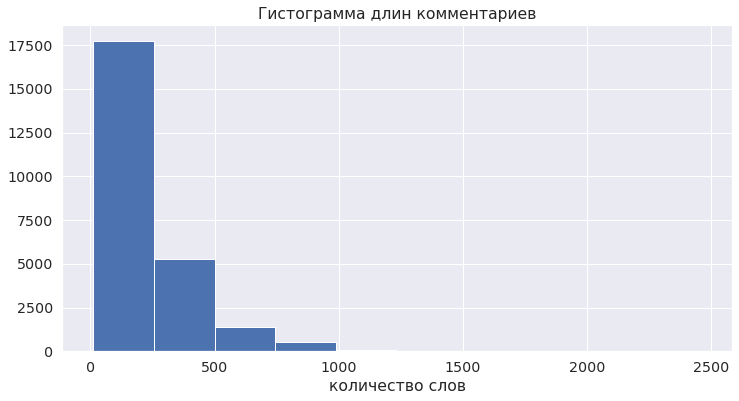

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(train['text'].apply(lambda x: len(x.split(' '))))
plt.title('Гистограмма длин комментариев')
plt.xlabel('количество слов')
plt.show()

Обрежем слишком длинные комментарии. В качестве максимальной длины возьмём $1000$ слов.

In [ ]:
def crop_text(text, max_length=1000):
    return ' '.join(text.split(' ')[:max_length])

In [ ]:
train['text'] = train['text'].apply(crop_text)
test['text'] = test['text'].apply(crop_text)

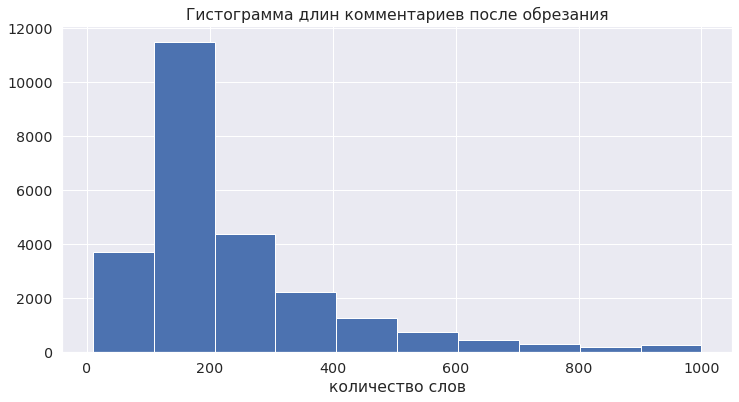

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(train['text'].apply(lambda x: len(x.split(' '))))
plt.title('Гистограмма длин комментариев после обрезания')
plt.xlabel('количество слов')
plt.show()

In [ ]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
train_dataset = TabularDataset('train.csv', 'csv', 
                               [('text', TEXT),
                                ('label', LABEL)], skip_header=True)
tst = TabularDataset('test.csv', 'csv', 
                               [('text', TEXT),
                                ('label', LABEL)], skip_header=True)

In [ ]:
trn, vld = train_dataset.split(0.8)

In [ ]:
TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=False,
        device=device,
        repeat=False
)

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train_loop(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    early_stopping=10,
    path_save=None,
    scheduler=None,
    history=None,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param early_stopping: ранняя остановка после стольких эпох без улучшений
    :param path_save: путь для сохранения модели с лучшим скором на валидации
    :param scheduler: learning rate scheduler
    :param history: предыдущая история обучения

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    if history is None:
        history = defaultdict(lambda: defaultdict(list))

    best_val_acc = 0
    no_improvements = 0

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        model.train() 

        for batch in train_batch_gen:
            X_batch = batch.text
            y_batch = batch.label

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.float().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = (logits >= 0.5).detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.eval() 

        for batch in val_batch_gen:
            X_batch = batch.text
            y_batch = batch.label
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.float().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = (logits >= 0.5).detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = 0
            no_improvements = 0
            if path_save is not None:
                torch.save(model, path_save)
        else:
            no_improvements += 1
        
        if scheduler is not None:
            scheduler.step()

        clear_output()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        if no_improvements >= early_stopping:
            print(f'Early stopping after {early_stopping} epochs without progress')
            break
        
    return model, history

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, linear_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.lin1 = nn.Linear(hidden_dim, linear_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.lin2 = nn.Linear(linear_dim, 1)
    
    def forward(self, x):
        x = x.permute(1, 0)
        x = self.emb(x)
        x = self.rnn(x)[1]
        x = self.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x).reshape(-1)
        return x

In [ ]:
vocab_size = len(TEXT.vocab)
emb_dim = 100
hidden_dim = 100
linear_dim = 50
model = BasicRNN(vocab_size, emb_dim, hidden_dim, linear_dim).to(device)

In [ ]:
learning_rate = 1e-4
num_epochs = 30 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
criterion = nn.BCEWithLogitsLoss()
path_save = 'drive/My Drive/Colab Models/Гринатом/basicrnn1.pt'

Epoch 30 of 30 took 15.452s
  training loss (in-iteration): 	0.081140
  validation loss (in-iteration): 	0.584939
  training accuracy: 			97.72 %
  validation accuracy: 			84.69 %


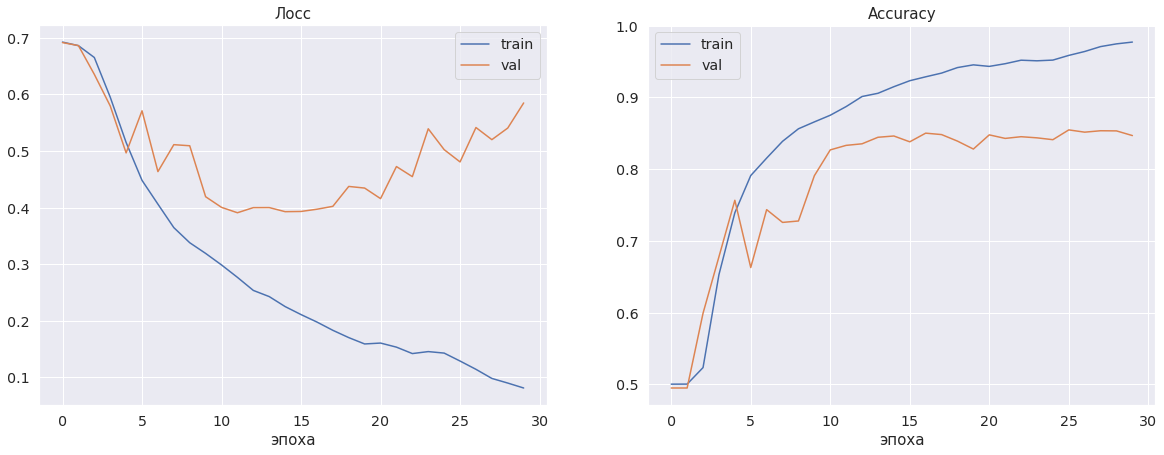

In [ ]:
model, history = train_loop(model, criterion, optimizer, train_iter, val_iter,
                       num_epochs, path_save=path_save)                 

In [ ]:
learning_rate = 1e-5
num_epochs = 30 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
criterion = nn.BCEWithLogitsLoss()
path_save = 'drive/My Drive/Colab Models/Гринатом/basicrnn2.pt'

Epoch 30 of 30 took 15.714s
  training loss (in-iteration): 	0.042246
  validation loss (in-iteration): 	0.629832
  training accuracy: 			99.10 %
  validation accuracy: 			85.13 %


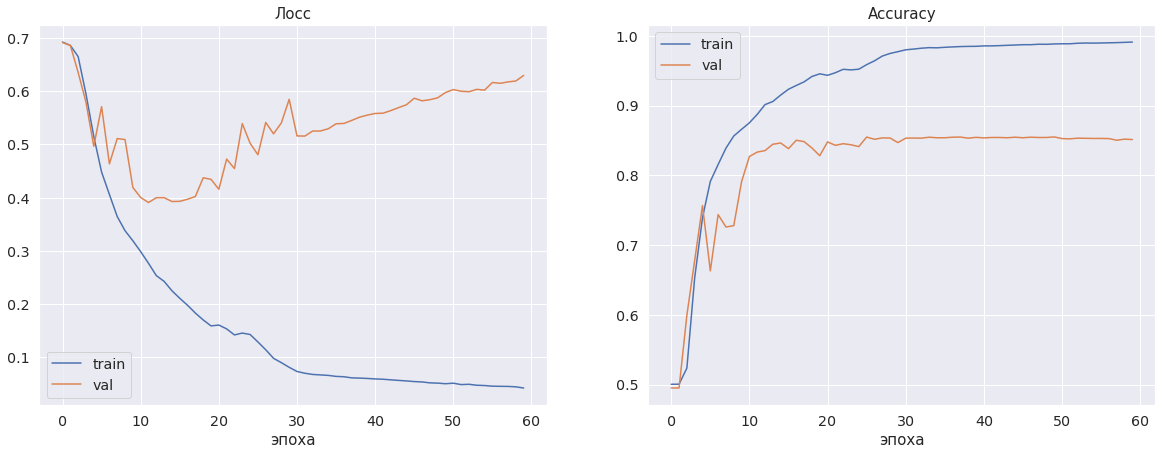

In [ ]:
model, history = train_loop(model, criterion, optimizer, train_iter, val_iter,
                       num_epochs, path_save=path_save, history=history)                 

In [ ]:
def score_on_test(model, test_batch_gen):
    model.eval()
    test_acc = 0
    for batch in test_batch_gen:
        X_batch = batch.text
        y_batch = batch.label
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        y_pred = (logits >= 0.5).detach().cpu().numpy()
        test_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    test_acc /= len(test_batch_gen)
    return test_acc

In [ ]:
print('accuracy на тесте:', round(score_on_test(model, test_iter), 4))

accuracy на тесте: 0.8418


Удалось немного улучшить качество.

Следующим шагом будет применение Transfer Learning: а именно, возьмём предобученный BERT из библиотеки `transformers`, у которого только последний слой для классификации проинициализирован случайно и обучим на наших данных. Веса самой модели будут также разморожены, то есть будет совмещение методов fine-tuning и feature-extractor. 


### BERT

In [ ]:
train = read_data('aclImdb/train')
train

,text,label
0,"Here, on IMDb.com I read an opinion, that Grey...",1
1,This short was nominated for an Academy Award ...,1
2,"As the one-line summary says, two movies have ...",1
3,The quintessential Georgian film of Georgi Dan...,1
4,This movie is finally out on DVD in Italy (com...,1
...,...,...
24995,I feel like I'm the only kid in town who was a...,0
24996,this is quite possibly the worst acting i have...,0
24997,Chesty gringo Telly Savalas (as Frank Cooper) ...,0
24998,"Okay, what the hell kind of TRASH have I been ...",0


In [ ]:
test = read_data('aclImdb/test')
test

,text,label
0,"To solve a challenging problem, you need to st...",1
1,Big Fat Liar is a great watch for kids of all ...,1
2,This 3 hour epic (seems much shorter) explores...,1
3,I put in the DVD expecting camp perversion fro...,1
4,I rented this movie for two reasons. The first...,1
...,...,...
24995,"This movie clearly has an agenda, which could ...",0
24996,Despite having an absolutely horrid script (mo...,0
24997,"My mother told me not to go to see ""Kadosh"" --...",0
24998,...now please move on because that's getting o...,0


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def tokenize(data, tokenizer, max_len=256):
    data = data.copy()
    data.loc[:, 'attention_masks'] = data.text.apply(
        lambda x: tokenizer.encode_plus(x, add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_attention_mask=True,
                                        return_tensors='pt')['attention_mask']
        )
    
    data.loc[:, 'input_ids'] = data.text.apply(
        lambda x: tokenizer.encode_plus(x, add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length = True,
                                        truncation=True,
                                        return_tensors = 'pt')['input_ids']
        )
   
    return data
    

In [ ]:
train_tokenized = tokenize(train, tokenizer)
test_tokenized = tokenize(test, tokenizer)

In [ ]:
train_dataset = TensorDataset(
    torch.cat(tuple(train_tokenized.input_ids.values), dim=0),
    torch.cat(tuple(train_tokenized.attention_masks.values), dim=0),
    torch.tensor(train_tokenized.label, dtype=torch.long)    
)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = TensorDataset(
    torch.cat(tuple(test_tokenized.input_ids.values), dim=0),
    torch.cat(tuple(test_tokenized.attention_masks.values), dim=0),
    torch.tensor(test_tokenized.label, dtype=torch.long)
)

len(train_dataset), len(val_dataset), len(test_dataset)

(20000, 5000, 25000)

In [ ]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset, 
            shuffle=True,
            batch_size = batch_size
        )

val_dataloader = DataLoader(
            val_dataset,
            shuffle=False,
            batch_size = batch_size 
        )

test_dataloader = DataLoader(
            test_dataset,
            shuffle=False,
            batch_size = batch_size 
        )

In [6]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,   
    output_attentions = False,
    output_hidden_states = False,
)

model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def train_loop(
    model, 
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    early_stopping=10,
    path_save=None,
    scheduler=None,
    history=None,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param early_stopping: ранняя остановка после стольких эпох без улучшений
    :param path_save: путь для сохранения модели с лучшим скором на валидации
    :param scheduler: learning rate scheduler
    :param history: предыдущая история обучения

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    if history is None:
        history = defaultdict(lambda: defaultdict(list))

    best_val_acc = 0
    no_improvements = 0

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        model.train() 

        for X_batch, attention_mask, y_batch in train_batch_gen:
            X_batch = X_batch.to(device)
            attention_mask = attention_mask.to(device)
            y_batch = y_batch.to(device)
            
            loss, logits = model(X_batch, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=y_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        model.eval() 

        for X_batch, attention_mask, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            attention_mask = attention_mask.to(device)
            y_batch = y_batch.to(device)
            
            loss, logits = model(X_batch, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=y_batch)
            
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        if val_acc > best_val_acc:
            best_val_acc = 0
            no_improvements = 0
            if path_save is not None:
                torch.save(model, path_save)
        else:
            no_improvements += 1
        
        if scheduler is not None:
            scheduler.step()

        clear_output()

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        if no_improvements >= early_stopping:
            print(f'Early stopping after {early_stopping} epochs without progress')
            break
        
    return model, history

In [ ]:
learning_rate = 3e-5
num_epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    
path_save = 'drive/My Drive/Colab Models/Гринатом/bert1.pt'

Epoch 3 of 3 took 1865.668s
  training loss (in-iteration): 	0.073625
  validation loss (in-iteration): 	0.311700
  training accuracy: 			97.52 %
  validation accuracy: 			90.02 %


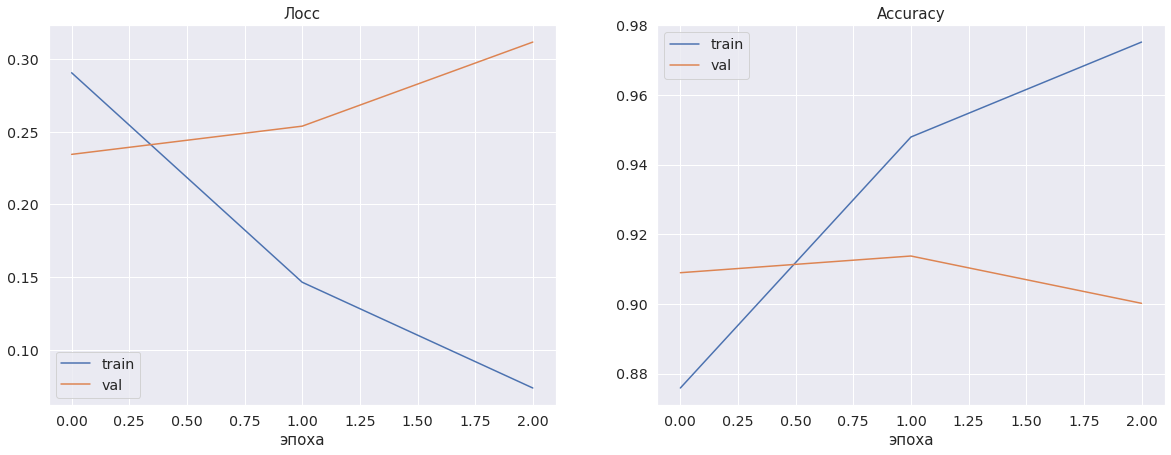

In [ ]:
model, history = train_loop(model, optimizer, train_dataloader,
                            val_dataloader, num_epochs, path_save=path_save)

In [ ]:
path_save = 'drive/My Drive/Colab Models/Гринатом/bert2.pt'

Epoch 3 of 3 took 1845.780s
  training loss (in-iteration): 	0.027341
  validation loss (in-iteration): 	0.368115
  training accuracy: 			99.17 %
  validation accuracy: 			91.81 %


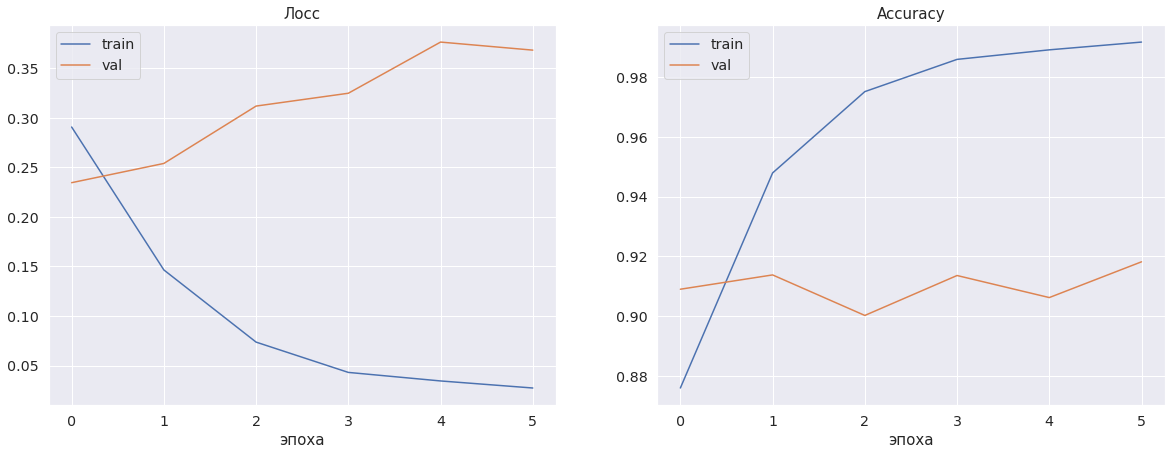

In [ ]:
model, history = train_loop(model, optimizer, train_dataloader,
                            val_dataloader, num_epochs, path_save=path_save,
                            history=history)                      

In [ ]:
model = torch.load('drive/My Drive/Colab Models/Гринатом/bert2.pt')
model.eval()
pass

In [ ]:
def score_on_test(model, test_batch_gen):
    model.eval()
    test_acc = 0
    for X_batch, attention_mask, y_batch in test_batch_gen:
            X_batch = X_batch.to(device)
            attention_mask = attention_mask.to(device)
            y_batch = y_batch.to(device)
            
            loss, logits = model(X_batch, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=y_batch)
            
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            test_acc += np.mean(y_batch.cpu().numpy() == y_pred)

    test_acc /= len(test_batch_gen)
    return test_acc

In [ ]:
%%time
print('accuracy на тесте:', round(score_on_test(model, test_dataloader), 4))

accuracy на тесте: 0.9137
CPU times: user 7min 11s, sys: 4min 22s, total: 11min 33s
Wall time: 11min 33s


Качество на тесте значительно улучшилось по сравнению с двумя предыдущими моделями. Кроме того, полученное качество превосходит результаты в рекомендованной статье($\approx 0.89$). Это, впрочем, неудивительно, ведь статья датируется 2011 годом, а мы использовали относительно современную модель.

Выберем эту модель для деплоя. Её результаты, несомненно, можно было бы улучшить, к примеру, взяв ещё более современные архитектуры, подобрав параметры оптимизатора, либо поменяв архитектуру(добавляем больше слоёв на классификацию). Можно было бы так же взять DistilBERT, чтобы упростить деплой модели, учитывая, что на сервере очень ограниченные ресурсы.

### Определение оценки отзыва

Так как модель предсказывает только вероятность того, что отзыв является позитивным, то необходимо научиться каким-то образом выставлять по этому рейтинг. На трейновой выборке вероятности могут быть слишком смещены из-за того, что модель как раз обучалась предсказывать вероятности для отзывов из трейна. Поэтому будем подбирать пороги по предсказаниям на тесте.

Сначала посмотрим на распределение оценок.

In [ ]:
ratings = []
path = 'aclImdb/test'
for dir in ['pos', 'neg']:
    dir_path = os.path.join(path, dir)
    files = os.listdir(dir_path)
    for file in files:
        rating = file.split('_')[1].split('.')[0]
        ratings.append(int(rating))


In [ ]:
rating_counts = list(np.unique(ratings, return_counts=True)[1])
#добавляем рейтинги 5 и 6
rating_counts = rating_counts[:4] + [0, 0] + rating_counts[4:]
rating_counts

[5022, 2302, 2541, 2635, 0, 0, 2307, 2850, 2344, 4999]

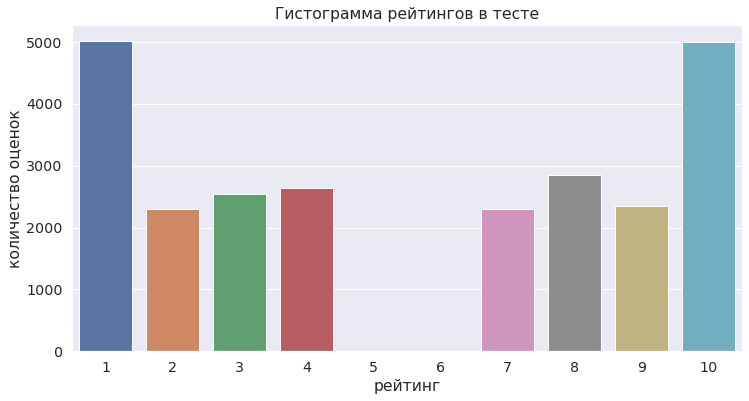

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=np.arange(10) + 1, y=rating_counts)
plt.title('Гистограмма рейтингов в тесте')
plt.xlabel('рейтинг')
plt.ylabel('количество оценок')
plt.show()

Оценки $5$ и $6$ в принципе отсутствуют в данных. Оценки $2-4$ и $7-9$ распределены примерно равномерно, а $1$ и $10$ -- более частые по сравнению с остальными. 

Визуализируем зависимость рейтинга от предсказанной вероятности(а точнее, её логарифма). Может быть, визуализация позволит вручную выбрать пороги вероятности, по которым будет определена оценка. Чем больше предсказанная вероятность, тем больше должна быть оценка, и наоборот.

In [ ]:
test_logprobs = []
model.eval()
for X_batch, attention_mask, y_batch in test_dataloader:
            X_batch = X_batch.to(device)
            attention_mask = attention_mask.to(device)
            y_batch = y_batch.to(device) 
            
            loss, logits = model(X_batch, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=y_batch)

            logprobs = F.log_softmax(logits)[:, 1]
            test_logprobs += list(logprobs.detach().cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


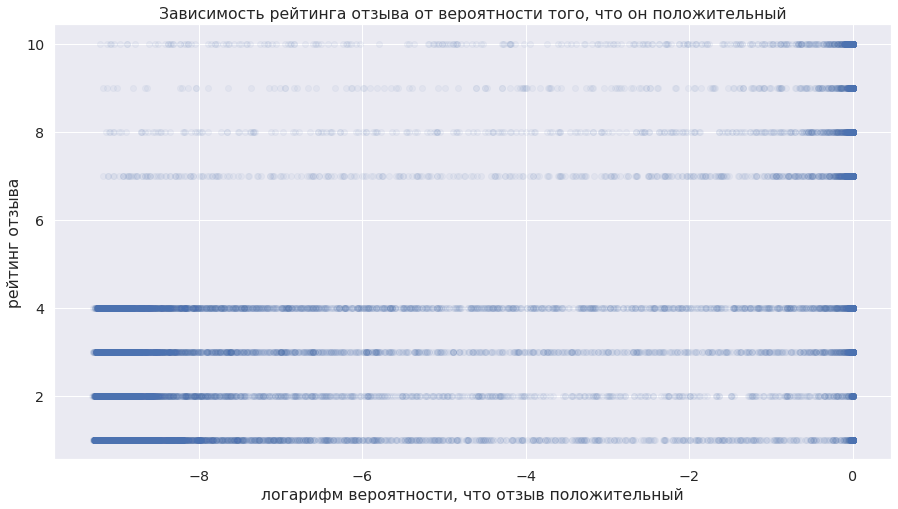

In [ ]:
plt.figure(figsize=(15, 8))
plt.scatter(test_logprobs, ratings, alpha=0.05)
plt.title('Зависимость рейтинга отзыва от вероятности того, что он положительный') 
plt.xlabel('логарифм вероятности, что отзыв положительный')
plt.ylabel('рейтинг отзыва')
plt.show()

По такому графику сложно подобрать какие-либо пороги разбиения.

Построим для каждого рейтинга ящик с усами логарифмов предсказанных вероятностей.

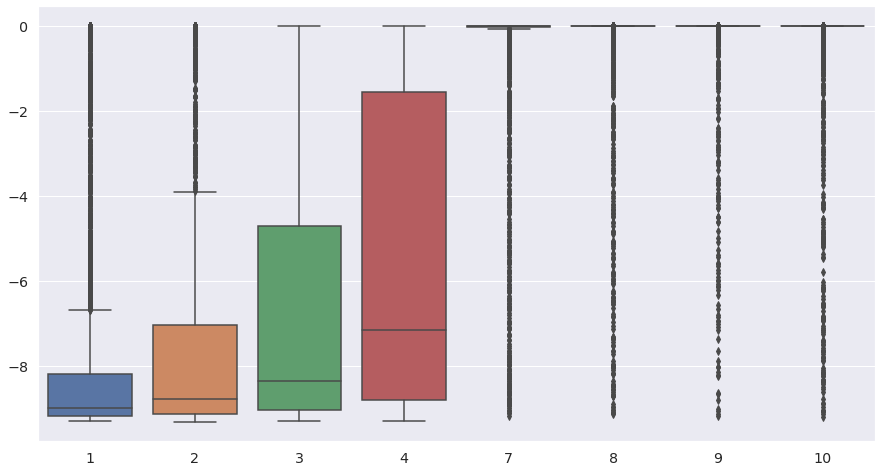

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(ratings, test_logprobs)
plt.show()

Для оценок $1-4$ ещё можно подобрать пороги по графику, а для оценок $7-10$ это уже не представляется возможным. Откажется от этого подхода и подберём пороги просто как выборочные квантили распределения логарифма вероятности. Это сделает предсказание оценок отзывов на тестовой выборке равномерным и, скорее всего, предсказанные оценки будут достаточно часто отличаться от истинных, но всё же будет хоть какой-то способ оценить рейтинг комментария. Это в любом случае было неизбежно, так как в данных отсутствуют комментарии с рейтингами $5$ и $6$. 

In [ ]:
np.quantile(test_logprobs, np.arange(0.1, 1, 0.1))

array([-9.15513935e+00, -8.93880043e+00, -8.27962961e+00, -5.53425903e+00,
       -3.35847884e-01, -1.01976395e-03, -2.50339508e-04, -2.18868256e-04,
       -1.99317932e-04])

Пример использования модели для обработки одного отзыва:

In [7]:
model = torch.load('drive/My Drive/Colab Models/Гринатом/bert2.pt',
                   map_location=device)
model.eval()
pass

In [52]:
def classify_comment(model, tokenizer, text, max_len=256):
    # квантили распределения логарифма вероятности, 
    # по которым будет выставлен рейтинг
    quantiles = np.array([-9.15513935e+00, -8.93880043e+00, -8.27962961e+00,
                          -5.53425903e+00, -3.35847884e-01, -1.01976395e-03,
                          -2.50339508e-04, -2.18868256e-04, -1.99317932e-04])
    model.eval()
    res = tokenizer.encode_plus(text, add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_attention_mask=True,
                                        return_tensors='pt')
    # батч состоит из одного элемента
    X_batch = res['input_ids']#.unsqueeze(0)
    attention_mask = res['attention_mask']#.unsqueeze(0)
    logits = model(X_batch, token_type_ids=None, 
                             attention_mask=attention_mask)[0]
    # положительный комментарий - 1, отрицательный - 0
    sentiment = logits.max(1)[1].detach().cpu().numpy().item()
    # логарифм вероятности того, что комментарий положительный
    logprob = F.log_softmax(logits, dim=1)[:, 1].item()
    score = np.sum(logprob >= quantiles) + 1

    return sentiment, score

In [54]:
classify_comment(model, tokenizer, 'This movie is the best.')

(1, 9)

Этот комментарий действительно положительный и соответствует высокой оценке.